<h1>Webpage Scrapping</h1>

In [1]:
from bs4 import BeautifulSoup
import requests # library to handle requests
import pandas as pd

In [38]:
source = requests.get("https://www.worldatlas.com/articles/biggest-cities-in-saudi-arabia.html").text
soup = BeautifulSoup(source, 'lxml')
#print(soup)

In [39]:
Saudi_table = soup.table
#print(Saudi_table.prettify())

In [4]:
import pandas as pd
Saudi_Cities = pd.read_html(str(Saudi_table), header=0)[0]
Saudi_Cities

,Rank,City,Population
0,1,Riyadh,6506700
1,2,Jeddah,3976400
2,3,Mecca,1919900
3,4,Medina,1271800
4,5,Al-Ahsa,1136900
5,6,Ta'if,1109800
6,7,Dammam,975800
7,8,Buraidah,658600
8,9,Khobar,626200
9,10,Tabuk,609000


In [5]:
Saudi_Cities = Saudi_Cities.drop(columns=['Rank','Population'])
Saudi_Cities.head()

,City
0,Riyadh
1,Jeddah
2,Mecca
3,Medina
4,Al-Ahsa


In [6]:
for i, row in Saudi_Cities.iterrows():
    print(row['City'])

Riyadh
Jeddah
Mecca
Medina
Al-Ahsa
Ta'if
Dammam
Buraidah
Khobar
Tabuk


In [7]:
col = ['CityName', 'latitude', 'longitude']
Saudi_loc = pd.DataFrame(columns = col)
for i, row in Saudi_Cities.iterrows():
    city_name = row['City']
    source = requests.get("https://en.wikipedia.org/wiki/"+ city_name).text
    soup = BeautifulSoup(source, 'lxml')
    try:
        loc = soup.find('span', class_="geo").text
        print(city_name , loc)
        Saudi_loc = Saudi_loc.append({col[0]:city_name, 
                                      col[1]:float(loc.split('; ')[0]), 
                                      col[2]:float(loc.split('; ')[1])}, ignore_index=True)
    except:
        print("location was not detected for", city_name)

Riyadh 24.633; 46.717
Jeddah 21.54333; 39.17278
Mecca 21.417; 39.817
Medina 24.467; 39.600
location was not detected for Al-Ahsa
Ta'if 21.433; 40.350
Dammam 26.433; 50.100
Buraidah 26.333; 43.967
Khobar 26.283; 50.200
location was not detected for Tabuk


In [8]:
Saudi_loc

,CityName,latitude,longitude
0,Riyadh,24.63300,46.71700
1,Jeddah,21.54333,39.17278
2,Mecca,21.41700,39.81700
3,Medina,24.46700,39.60000
4,Ta'if,21.43300,40.35000
5,Dammam,26.43300,50.10000
6,Buraidah,26.33300,43.96700
7,Khobar,26.28300,50.20000


In [9]:
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

address = 'Saudi Arabia'

geolocator = Nominatim(user_agent="Saudi_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Saudi Arabia are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Saudi Arabia are 25.6242618, 42.3528328.


In [10]:
import folium
map_Saudi = folium.Map(location=[latitude, longitude], zoom_start=6)

for lat, lng, city in zip(Saudi_loc['latitude'], Saudi_loc['longitude'], Saudi_loc['CityName']):
    label = folium.Popup(city, parse_html=True)
    folium.Marker([lat, lng], popup = label).add_to(map_Saudi)
map_Saudi

<h1>Application programming interface (API)</h1>

In [11]:
Saudi_loc

,CityName,latitude,longitude
0,Riyadh,24.63300,46.71700
1,Jeddah,21.54333,39.17278
2,Mecca,21.41700,39.81700
3,Medina,24.46700,39.60000
4,Ta'if,21.43300,40.35000
5,Dammam,26.43300,50.10000
6,Buraidah,26.33300,43.96700
7,Khobar,26.28300,50.20000


يجب تغيير القيمة في متغير 
</br>CityID</br>
حسب المدينة المراد تحليل مواقعها
القيمة 0 تشير إلى مدينة الرياض والقيمة 1 تشير إلى مدينة جدة وهكذا

In [31]:
CLIENT_ID = 'ZLNCVVDMUTSIAICKT103POACTFZMR4COUZMCMB4UUN5MYA3X' # your Foursquare ID
CLIENT_SECRET = 'SCRJ41NA15ZHMBPSEMB115J3SBV33QTBTMUQ25CZJOBWEBKH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
CityID = 0
cityLatitude = Saudi_loc.loc[CityID, 'latitude']
cityLongitude = Saudi_loc.loc[CityID, 'longitude']

In [32]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 80000 # define radius


 # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    cityLatitude, 
    cityLongitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=ZLNCVVDMUTSIAICKT103POACTFZMR4COUZMCMB4UUN5MYA3X&client_secret=SCRJ41NA15ZHMBPSEMB115J3SBV33QTBTMUQ25CZJOBWEBKH&v=20180605&ll=24.633,46.717&radius=80000&limit=100'

In [33]:
import requests
results = requests.get(url).json()


In [34]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [35]:
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Al Zal Bazaar (سوق الزل التراثي),Antique Shop,24.629318,46.712572
1,National Museum (المتحف الوطني),History Museum,24.646388,46.710302
2,King Abdulaziz Foundation (دارة الملك عبدالعزيز),History Museum,24.647263,46.708253
3,Saravana Bhavan,South Indian Restaurant,24.663358,46.704458
4,AlNaqaa (حمص النقاء),Breakfast Spot,24.667307,46.733412


In [36]:
address = Saudi_loc.loc[CityID, 'CityName']+', Saudi Arabia'

geolocator = Nominatim(user_agent="Saudi_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_City = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, venue in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['categories']):
    label = folium.Popup(venue, parse_html=True)
    folium.CircleMarker(
       [lat, lng],
       radius=6,
       popup=label,
       color='green',
       fill=True,
       fill_color='#008000',
       fill_opacity=0.4,
       parse_html=False).add_to(map_City)  
map_City

,categories,count
10,Coffee Shop,9
49,Supermarket,8
13,Dessert Shop,5
30,Jewelry Store,4
28,Ice Cream Shop,4


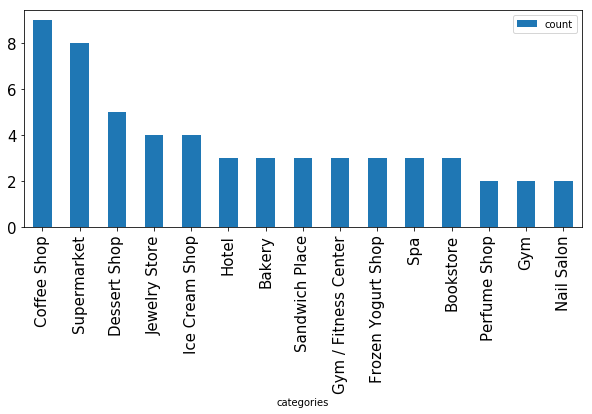

In [37]:
common_ven = nearby_venues.groupby('categories').size().to_frame(name = 'count'
                                                                ).reset_index().sort_values(by=['count'], ascending=False
                                                                                           ).head(15)
common_ven.plot.bar(x='categories', figsize=(10,4), fontsize=15)
common_ven.head()